In [81]:
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing
from tqdm import tqdm
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from skimage.transform import resize
from collections import Counter

sn.set()

from sklearn.svm import SVC # SVC
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier # XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [82]:
no_angles = 360
url ='/kaggle/input/mias-mammography/all-mias/'

In [83]:
def read_image():
    print("Reading images")
    import cv2
    info = {}
    for i in range(322):
        if i<9:
            image_name='mdb00'+str(i+1)
        elif i<99:
            image_name='mdb0'+str(i+1)
        else:
            image_name = 'mdb' + str(i+1)
        # print(image_name)
        image_address= url+image_name+'.pgm'
        #print(image_address)
        #print(image_address)
        img = cv2.imread(image_address,1)
        # print(i)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (100,100))   #resize image

        rows, cols = img.shape
        info[image_name]={}
        for angle in range(0,no_angles,180):
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)    #Rotate 0 degree
            img_rotated = cv2.warpAffine(img, M, (cols, rows))
            info[image_name][angle]=img_rotated
    return (info)

In [84]:
def read_lable():
    print("Reading labels")
    filename = url+'Info.txt'
    text_all = open(filename).read()
    #print(text_all)
    lines=text_all.split('\n')
    info={}
    for line in lines:
        words=line.split(' ')       
        if len(words)>3:
            if (words[3] == 'B'):
                info[words[0]] = {}
                for angle in range(0,no_angles,180):
                    info[words[0]][angle] = 0
            if (words[3] == 'M'):
                info[words[0]] = {}
                for  angle in range(0,no_angles,180):
                    info[words[0]][angle] = 1
    return (info)

In [85]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
lable_info=read_lable()
image_info=read_image()
#print(image_info[1][0])
ids=lable_info.keys()   #ids = acceptable labeled ids
#print(type(ids))
del lable_info['Truth-Data:']
#print(lable_info)
#print(ids)
X=[]
Y=[]
for id in ids:
    X.append(image_info[id][0])
    Y.append(lable_info[id][0])

left_images=[]
right_images=[]
labels=[]

for i in range(len(X)):
    for j in range(len(X)):
        if i>=j:
            continue
            
        left_images.append(X[i])
        right_images.append(X[j])
        
        if Y[i]==Y[j]:
            labels.append(1)
        else:
            labels.append(0)

Reading labels
Reading images


In [86]:
left_train,left_test,right_train,right_test,labels_train, labels_test = train_test_split(left_images,right_images,labels,test_size=0.30, random_state=2021,shuffle=True)

In [87]:
left_train=np.array(left_train)/255.
right_train=np.array(right_train)/255.
labels_train=np.array(labels_train)
left_test=np.array(left_test)/255.
right_test=np.array(right_test)/255.
labels_test=np.array(labels_test)

from sklearn.utils import shuffle
left_train,right_train,labels_train = shuffle(left_train,right_train,labels_train)
left_test,right_test,labels_test = shuffle(left_test,right_test,labels_test)

In [88]:
from keras import backend as K
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [89]:
input_dim = (100,100,1)

In [90]:
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras import optimizers
from keras.models import load_model
from keras import applications

from keras import callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
import os
from keras.models import Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
import warnings
warnings.filterwarnings('ignore')

In [91]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    kernel_size = 3
    
    seq.add(Convolution2D(64, (kernel_size, kernel_size), input_shape=input_shape))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
    
    seq.add(Convolution2D(32, (kernel_size, kernel_size)))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))
    
    #flatten 
    seq.add(Flatten())
    seq.add(Dense(64, activation='relu'))
    return seq

base_network = build_base_network(input_dim)

img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

prediction = Dense(1,activation='sigmoid')(distance) #1 neuron, sigmoid shrinks distance between 0 and 1.

In [92]:
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3, #tolerates 3 times opposition
                              verbose=1) #shows in terminal

callback_early_stop_reduceLROnPlateau=[earlyStopping]

In [93]:
model = Model([img_a, img_b],prediction)
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 64)           1102560     input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 1)            0           sequential_4[0][0]    

In [94]:
model.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(lr=5e-5),metrics=["accuracy"])

In [95]:
history = model.fit([left_train,right_train],labels_train, validation_split=.10,shuffle=True,
      batch_size= 8, verbose=1, epochs=10)

Epoch 1/10
517/517 [==============================] - 4s 7ms/step - loss: 0.6957 - accuracy: 0.5040 - val_loss: 0.6917 - val_accuracy: 0.5185
Epoch 2/10
517/517 [==============================] - 3s 7ms/step - loss: 0.6936 - accuracy: 0.5040 - val_loss: 0.6927 - val_accuracy: 0.5185
Epoch 3/10
517/517 [==============================] - 3s 6ms/step - loss: 0.6934 - accuracy: 0.5038 - val_loss: 0.6922 - val_accuracy: 0.5185
Epoch 4/10
517/517 [==============================] - 3s 6ms/step - loss: 0.6932 - accuracy: 0.5040 - val_loss: 0.6930 - val_accuracy: 0.5163
Epoch 5/10
517/517 [==============================] - 3s 6ms/step - loss: 0.6929 - accuracy: 0.5038 - val_loss: 0.6932 - val_accuracy: 0.5120
Epoch 6/10
517/517 [==============================] - 3s 6ms/step - loss: 0.6926 - accuracy: 0.5086 - val_loss: 0.6930 - val_accuracy: 0.4967
Epoch 7/10
517/517 [==============================] - 3s 6ms/step - loss: 0.6924 - accuracy: 0.5120 - val_loss: 0.6944 - val_accuracy: 0.5207
Epoch 

<Figure size 432x288 with 0 Axes>

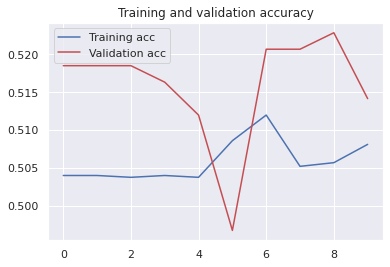

<Figure size 432x288 with 0 Axes>

In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

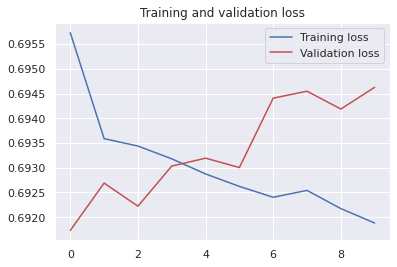

In [97]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [98]:
print(right_test[0].shape)

(100, 100)


In [99]:
pred_y = model.predict([left_test,right_test])
pred_y=[1 if x>0.5 else 0 for x in pred_y]

In [100]:
from sklearn.metrics import accuracy_score
accuracy_score(pred_y, labels_test)

0.48347737671581087